In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from tdse.matrix_py import mat_vec_mul_tridiag
from tdse.matrix_py import gaussian_elimination_tridiagonal

def tridiag_forward(tridiag, v, b):
    b[:] = mat_vec_mul_tridiag(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], v)

def tridiag_backward(tridiag, v, b):
    v[:] = gaussian_elimination_tridiagonal(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], b)

# Parameter

- may be replaced by input file read

In [3]:
R_in = 50.03
delta_x = 0.2
imag_pot_width = 30.0
delta_t_real = 0.05
# V_x_func = lambda x: np.zeros_like(x)
# V_x_func = lambda x: - np.exp(-x*x)
V_x_func = lambda x: 0.001 * x*x
A_t_func = lambda t: np.zeros_like(t)
t_max_in = 33.98
t0 = 0.0

imag_prop = True

### Check parameters

In [4]:
assert R_in > 0 and delta_x > 0 and imag_pot_width > 0 and delta_t_real > 0
from numbers import Integral

# Construct coordinates arrays

## spatial array

In [5]:
N_x = 2 * int(R_in // delta_x) + 1
N_x_width = N_x // 2
R = delta_x * N_x_width
assert R == (R_in - (R_in % delta_x))
x_arr = np.linspace(-R,R,N_x)
assert np.isclose(x_arr[1] - x_arr[0],delta_x, atol=1e-14, rtol=0)

## temporal array

In [6]:
N_timestep = int( (t_max_in - t0 + delta_t_real) // delta_t_real )
t_max = t0 + delta_t_real * N_timestep
N_timepoint = N_timestep + 1
t_arr = np.linspace(t0, t_max, N_timepoint)
assert np.isclose(t_arr[1] - t_arr[0], delta_t_real, atol=1e-14, rtol=0)

# Construct potential arrays: $V(x)$, $A(t)$

In [7]:
V_x_arr = V_x_func(x_arr)
A_t_arr = A_t_func(t_arr)

# Construct tridiagonals

## intermediate matrices

In [8]:
tridiag_shape = (3,N_x)

M2 = np.empty(tridiag_shape, dtype=float)
M2[0,1:], M2[1,:], M2[2,:-1] = 1.0/12.0, 10.0/12.0, 1.0/12.0

D2 = np.empty(tridiag_shape, dtype=float)
D2[0,1:], D2[1,:], D2[2,:-1] = 1.0, -2.0, 1.0
D2 *= 1.0 / (delta_x * delta_x)

M2V = np.empty(tridiag_shape, dtype=float)
M2V[0,1:], M2V[1,:], M2V[2,:-1] = M2[0,1:] * V_x_arr[:-1], M2[1,:] * V_x_arr[:], M2[2,:-1] * V_x_arr[1:]

M1 = np.empty(tridiag_shape, dtype=float)
M1[0,1:], M1[1,:], M1[2,:-1] = 1.0/6.0, 2.0/3.0, 1.0/6.0

D1 = np.empty(tridiag_shape, dtype=float)
D1[0,1:], D1[1,:], D1[2,:-1] = -1.0, 0.0, 1.0
D1 *= 1.0 / (2.0 * delta_x)

## unitary

- [ ] Later, consider putting the imaginary potential into the real part of the unitary operator

In [9]:
delta_t = delta_t_real
if imag_prop: 
    delta_t *= (-1.0j)
    A_t_func = lambda t: np.zeros_like(t)

In [10]:
U0_half = np.empty(tridiag_shape, dtype=complex)
U0_half[:] = M2 - 1.0j * delta_t * 0.25 * (-0.5 * D2 + M2V)
U0_conj_half = np.empty(tridiag_shape, dtype=complex)
U0_conj_half[:] = M2 + 1.0j * delta_t * 0.25 * (-0.5 * D2 + M2V)
# U0_half.imag = - delta_t * 0.25 * (-0.5 * D2 + M2V)

U0 = np.empty(tridiag_shape, dtype=complex)
U0[:] = M2 - 1.0j * delta_t * 0.5 * (-0.5 * D2 + M2V)
U0_conj = np.empty(tridiag_shape, dtype=complex)
U0_conj[:] = M2 + 1.0j * delta_t * 0.5 * (-0.5 * D2 + M2V)
# U0.real = M2
# U0.imag = - delta_t * 0.5 * (-0.5 * D2 + M2V)

# Set initial state function

In [11]:
sf_shape = (N_x,)
sf_arr_0 = np.empty(sf_shape, dtype=complex)
sf_arr = np.empty(sf_shape, dtype=complex)

sf_arr_0[:] = np.random.rand(*sf_shape) - 0.5
# from tdse.analytic import Gaussian1D
# sf_arr_0[:] = Gaussian1D(x_arr, t0, k_x=0.0)

sf_arr[:] = sf_arr_0.copy()

## Plot

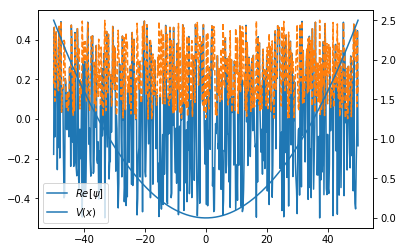

In [12]:
fig_ini, ax_ini = plt.subplots()
l_sf_real, = ax_ini.plot(x_arr, sf_arr_0.real)
l_sf_abs, = ax_ini.plot(x_arr, np.abs(sf_arr_0), '--')

ax_energy = ax_ini.twinx()
l_pot, = ax_energy.plot(x_arr, V_x_arr, '-')

ax_ini.legend((l_sf_real, l_pot),(r'$Re[\psi]$','$V(x)$'))

# Propagation

### Preparation

In [13]:
sf_arr_mid = np.empty_like(sf_arr, dtype=complex)

UA = np.empty(tridiag_shape, dtype=complex)
UA_conj = np.empty(tridiag_shape, dtype=complex)
# UA.imag = 0.0

In [14]:
t_idx = 0
t = 0.5 * (t_arr[t_idx] + t_arr[t_idx+1])
A_t = A_t_func(t)

# UA.real = M1 - delta_t * 0.5 * A_t * D1
UA[:] = M1 - delta_t * 0.5 * A_t * D1

tridiag_forward(U0_half, sf_arr, sf_arr_mid)
tridiag_backward(U0_conj_half, sf_arr, sf_arr_mid)
tridiag_forward(UA, sf_arr, sf_arr_mid)
tridiag_backward(UA.conj(), sf_arr, sf_arr_mid)

for t_idx in range(1,N_timestep):

    t = 0.5 * (t_arr[t_idx] + t_arr[t_idx+1])
    A_t = A_t_func(t)

#     UA.real = M1 - delta_t * 0.5 * A_t * D1
    UA[:] = M1 - delta_t * 0.5 * A_t * D1

    tridiag_forward(U0, sf_arr, sf_arr_mid)
    tridiag_backward(U0_conj, sf_arr, sf_arr_mid)
    tridiag_forward(UA, sf_arr, sf_arr_mid)
    tridiag_backward(UA.conj(), sf_arr, sf_arr_mid)
    
tridiag_forward(U0_half, sf_arr, sf_arr_mid)
tridiag_backward(U0_conj_half, sf_arr, sf_arr_mid)

# Analytical result

In [15]:
sf_arr_ana = np.empty_like(sf_arr_0, dtype=complex)
# sf_arr_ana[:] = Gaussian1D(x_arr, t=t_max, k_x=0.0)
sf_arr_ana = np.zeros_like(sf_arr_0)

# Visualization

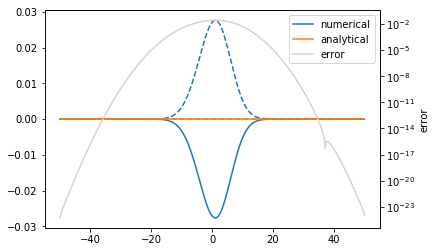

In [16]:
fig, ax = plt.subplots()

l_num, = ax.plot(x_arr, sf_arr.real)
ax.plot(x_arr, np.abs(sf_arr), '--', color=l_num.get_color())

l_ana, = ax.plot(x_arr, sf_arr_ana.real)
ax.plot(x_arr, np.abs(sf_arr_ana), '--', color=l_ana.get_color())

ax2 = ax.twinx()
l_error, = ax2.semilogy(x_arr, np.abs(sf_arr - sf_arr_ana), color='lightgrey')
ax2.set_ylabel('error')

ax.legend((l_num,l_ana, l_error),('numerical','analytical','error'))